# 8. PCA

In [330]:
from fixedincome2025 import table

## Overview

* So far we have covered
    * (Treasury) yield curve construction: A snap shot of the market
    * Duration and convexity: What happens to the portfolio value if the curve moves parallelly
    * Delta ladder: What happens to the portfolio value if the curve moves but not parallelly
* Something is missing: How will tomorrow's curve move?
    * Of course no one knows exactly, but we can still say something
* Principal component analysis (PCA) provides a great tool to model yield curve movements and to hedge any portfolios that have rates exposure

## Modeling Yield Curve Movements

* Although the below curve has 14 points, when we model this curve's movement, we should not model it by 14 independent random variables

In [331]:
table('yc_10092025').T

,1m,1.5m,2m,3m,4m,6m,1y,2y,3y,5y,7y,10y,20y,30y
Yield,4.2%,4.17%,4.11%,4.03%,3.95%,3.83%,3.66%,3.6%,3.59%,3.74%,3.92%,4.14%,4.7%,4.72%


* Rates for nearby maturities on the curve tend to move together—both in direction and magnitude—because the corresponding bonds are close substitutes.
    * If 2y bond is too expensive, investors with the need can just buy 3y bond
    * If borrowing for 2y is too expensive, borrowers can just borrow for 3y
* As we will see now, PCA tells us 3 independent random variables are enough
* First we need some math

## Singular Value Decomposition (SVD)

* Every $m\times n$ matrix $X$ can be written as
$$
X = USV^{\mathsf T}, 
$$
where
    * $U$ is an $m\times m$ unitary matrix (more on unitary matrices later)
    * $V$ is an $n\times n$ unitary matrix
    * $S$ is an $m\times n$ matrix with nonzero entries only on the main diagonal, meaning if $S=(s_{ij})$, then $s_{ij} \neq 0$ only when $i = j$. Also the nonzero elements are sorted, meaning $s_{11} \geq s_{22} \geq s_{33} \geq \cdots \geq s_{nn}$. They are known as the singular values of $X$
* For our purpose which is to model the curve movement, the important case is $m>n$

## The $S$ Matrix

$$
S = \begin{pmatrix}
s_{11} & 0 & \cdots & 0\\ 
0 & s_{22} & \cdots & 0\\ 
\vdots & \vdots & \ddots & \vdots\\ 
0 & 0 & \cdots & s_{nn}\\ 
\vdots & \vdots & \vdots & \vdots\\ 
0 & 0 & \cdots & 0\\ 
\end{pmatrix}_{m\times n}
$$
* $s_{11} \geq s_{22} \geq s_{33} \geq \cdots \geq s_{nn}$

## Unitary Matrix

* Recall that $X_{m\times n} = USV^{\mathsf T}$, where $U_{m\times m}$ and $V_{n\times n}$ are both unitary
* Definition: A matrix $V_{n\times n}$ is said to be unitary if $V^{\mathsf T}V = I_n$, the $n\times n$ identity matrix
* Easy to compute inverse: $V^{-1} = V^{\mathsf T}$ by definition
* Let
$$
V = \begin{pmatrix}
|&|&  & | \\
v_1 & v_2 & \cdots & v_n \\
|&|&  & | \\
\end{pmatrix}, 
$$
where $v_j$ are column vectors

## Unitary Matrix (Cont.)

* $V^{\mathsf T}V = I_n$: 
\begin{align*}
V^{\mathsf T}V &= \begin{pmatrix}
\frac{\qquad}{} & v_1^{\mathsf T} & \frac{\qquad}{} \\
\frac{\qquad}{} & v_2^{\mathsf T} & \frac{\qquad}{} \\
& \vdots & \\
\frac{\qquad}{} & v_n^{\mathsf T} & \frac{\qquad}{} \\
\end{pmatrix}
\begin{pmatrix}
|&|&  & | \\
v_1 & v_2 & \cdots & v_n \\
|&|&  & | \\
\end{pmatrix}\\
&= \begin{pmatrix}
\langle v_1, v_1\rangle & \langle v_1, v_2\rangle & \cdots & \langle v_1, v_n\rangle\\
\langle v_2, v_1\rangle & \langle v_2, v_2\rangle & \cdots & \langle v_2, v_n\rangle\\
\vdots&\vdots&\ddots&\vdots \\
\langle v_n, v_1\rangle & \langle v_n, v_2\rangle & \cdots & \langle v_n, v_n\rangle
\end{pmatrix} = \begin{pmatrix}
1 & 0 & \cdots & 0\\
0 & 1 & \cdots & 0\\
\vdots&\vdots&\ddots&\vdots \\
0 & 0 & \cdots & 1
\end{pmatrix}, 
\end{align*}
where $\langle \cdot, \cdot\rangle$ stands for the inner product of two vectors
* Unitary means
    * The column vectors have norm 1 and
    * Inner product of any two different column vectors is 0

## Vector Norm

* Let $\vec a = (a_1, a_2, \ldots, a_n)^{\mathsf T}$ be a column vector. Then its norm is
\begin{align*}
\lVert \vec a \rVert = \sqrt{\langle a, a\rangle} = \sqrt{a_1^2 + a_2^2 + \cdots + a_n^2}
\end{align*}
* Norm is the "length" of a vector in high dimensions

## Inner Product

* If $\vec a = (a_1, a_2, \ldots, a_n)^{\mathsf T}$ and $\vec b = (b_1, b_2, \ldots, b_n)^{\mathsf T}$, then 
\begin{align*}
\langle \vec a, \vec b\rangle &= \vec a^{\mathsf T}\vec b = \vec b^{\mathsf T}\vec a \\
&= a_1b_1 + a_2b_2 + \cdots + a_nb_n
\end{align*}

## Zero Inner Product in 2D

* Two vectors having zero inner product basically means they are "perpendicular"
* Take 2D as an example. If $v_1$ and $v_2$ are in 2D and $\langle v_1, v_2\rangle = 0$, write in polar coordinates
\begin{align*}
v_1 &= (r_1 \cos \theta_1, r_1 \sin \theta_1)^{\mathsf T}, \\
v_2 &= (r_2 \cos \theta_2, r_2 \sin \theta_2)^{\mathsf T}. 
\end{align*}
Then $\langle v_1, v_2\rangle = 0$ means
\begin{align*}
r_1 r_2 (\cos \theta_1 \cos \theta_2 + \sin \theta_1\sin \theta_2) = r_1 r_2 \cos (\theta_1 - \theta_2) = 0. 
\end{align*}
So $\theta_1 - \theta_2 = 90^{\circ}$ (plus multiples of $180^{\circ}$), so $v_1$ and $v_2$ are perpendicular.

* In general, in 2D and 3D, inner product has the property
$$
\langle \vec a, \vec b\rangle = \lVert \vec a \rVert\lVert \vec b \rVert \cos\theta,
$$
where $\theta$ is the angle between the two vectors

## Perpendicular in 2D

* Perpendicular 2D vectors with norm 1 are just rotation of $(1, 0)^{\mathsf T}$ and $(0, 1)^{\mathsf T}$

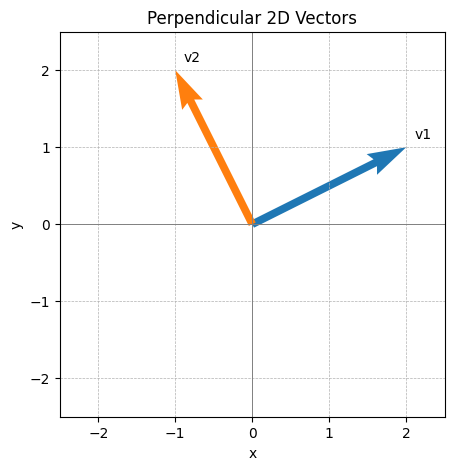

In [332]:
import numpy as np
import matplotlib.pyplot as plt

# Example vectors in 2D
v1 = np.array([2.0, 1.0])
# perpendicular vector obtained by rotating v1 by 90 degrees: [-y, x]
v2 = np.array([-v1[1], v1[0]])

fig, ax = plt.subplots(figsize=(5,5))
# draw thin axes lines
ax.axhline(0, color='gray', linewidth=0.7)
ax.axvline(0, color='gray', linewidth=0.7)

# plot vectors using quiver so lengths are respected
ax.quiver(0, 0, v1[0], v1[1], angles='xy', scale_units='xy', scale=1, color='C0', width=0.02)
ax.quiver(0, 0, v2[0], v2[1], angles='xy', scale_units='xy', scale=1, color='C1', width=0.02)

# annotate tips
ax.annotate('v1', xy=(v1[0], v1[1]), xytext=(6,6), textcoords='offset points')
ax.annotate('v2', xy=(v2[0], v2[1]), xytext=(6,6), textcoords='offset points')

# determine symmetric plot limits and enforce equal aspect ratio
max_coord = np.max(np.abs(np.vstack((v1, v2)))) * 1.25
ax.set_xlim(-max_coord, max_coord)
ax.set_ylim(-max_coord, max_coord)
ax.set_aspect('equal', adjustable='box')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Perpendicular 2D Vectors')
ax.grid(True, linestyle='--', linewidth=0.5)
plt.show()

## Zero Inner Product in 3D

* Similarly, in 3D, $\langle v_1, v_2\rangle = \langle v_1, v_3\rangle = \langle v_2, v_3\rangle = 0$ means the 3 vectors are mutually perpendicular
* This can be shown by first writing the vectors in spherical coordinates
\begin{align*}
\begin{cases}
x = \sin \phi \cos \theta\\
y = \sin \phi \sin \theta\\
z = \cos \phi
\end{cases}, 
\end{align*}
but I'll spare you the details

## Perpendicular in 3D

* Mutually perpendicular 3D vectors with norm 1 are just "rotation" of $(1, 0, 0)^{\mathsf T}$, $(0, 1, 0)^{\mathsf T}$ and $(0, 0, 1)^{\mathsf T}$

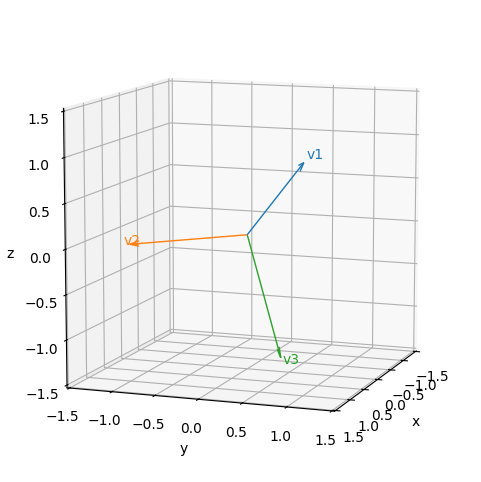

In [333]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define three mutually perpendicular vectors in 3D
v1 = np.array([1.0, 1.0, 1.0])
v2 = np.array([1.0, -1.0, 0.0])  # v1.dot(v2) = 0
# v3 is chosen as the cross product v1 x v2 to ensure orthogonality and then scaled
v3 = np.cross(v1, v2)
v3 = v3 / np.linalg.norm(v3) * 1.5

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

# plot arrows from origin; arrow_length_ratio controls head size
ax.quiver(0, 0, 0, v1[0], v1[1], v1[2], color='C0', linewidth=1, arrow_length_ratio=0.08)
ax.quiver(0, 0, 0, v2[0], v2[1], v2[2], color='C1', linewidth=1, arrow_length_ratio=0.08)
ax.quiver(0, 0, 0, v3[0], v3[1], v3[2], color='C2', linewidth=1, arrow_length_ratio=0.08)

# annotate tips
ax.text(*(v1 * 1.05), 'v1', color='C0')
ax.text(*(v2 * 1.05), 'v2', color='C1')
ax.text(*(v3 * 1.05), 'v3', color='C2')

# symmetric limits around origin
max_coord = np.max(np.abs(np.vstack((v1, v2, v3)))) * 1.25
ax.set_xlim(-max_coord, max_coord)
ax.set_ylim(-max_coord, max_coord)
ax.set_zlim(-max_coord, max_coord)

# enforce equal aspect ratio if supported
try:
    ax.set_box_aspect([1,1,1])
except Exception:
    # older matplotlib: approximate equal aspect by leaving symmetric limits
    pass

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.set_title('Three Mutually Perpendicular 3D Vectors')
# Set a camera view (elevation, azimuth) to make perpendicular relationships easier to see
ax.view_init(elev=10, azim=20)
plt.show()

## Zero Inner Product in General ($n$-D)

* In 2D there can be at most 2 vectors that are mutually perpendicular
* In 3D there can be at most 3 vectors that are mutually perpendicular
* In general, in $n$-D there can be at most $n$ vectors that are mutually perpendicular
    * In fact that's the definition of the dimension in linear algebra: Maximum number of vectors one can find in a space that's mutually independent
    * Given a set of mutually independent vectors, mutually perpendicular vectors can be constructed through the Gram-Schmidt process

* An $n\times n$ unitary matrix is one whose $n$ column vectors are mutually perpendicular with norm 1
* Such $n$ vectors are just rotation of the so called standard basis $(1, 0,\ldots, 0)^{\mathsf T}$, $(0, 1,\ldots, 0)^{\mathsf T}$ and $(0, 0,\ldots, 1)^{\mathsf T}$

## Unitary Matrix as a Rotation Matrix

* 2D unit vector has the general form $(\cos\theta, \sin\theta)^{\mathsf T}$

* A 2D unit vector that's perpendicular to $(\cos\theta, \sin\theta)^{\mathsf T}$ must be (?) $(\cos(\theta+\pi/2), \sin(\theta+\pi/2))^{\mathsf T} = (-\sin\theta, \cos\theta)^{\mathsf T}$
    * The direction is unique but sign can change, that is, $-(-\sin\theta, \cos\theta)^{\mathsf T}$ is also a perpendicular vector

* Thus $2\times 2$ unitary matrices have the general form
\begin{align*}
R = 
\begin{pmatrix}
\cos\theta & -\sin\theta \\
\sin\theta & \cos\theta\\
\end{pmatrix},
\end{align*}
which is a rotation matrix

* $R$ has a property that $R\vec v$ rotates the direction of $\vec v$ counterclockwise through $\theta$
* In general, an $n\times n$ unitary matrix is a rotation matrix that, when multiplied by an $n$-D vector, rotates the vector

## One Property of SVD

* Recall that $X_{m\times n} = USV^{\mathsf T}$ with $m>n$. We will write $T = US$ and $X = TV^{\mathsf T}$: 
\begin{align*}
X_{m\times n} &= \begin{pmatrix}
&\\
|&|&  &&& | \\\\
u_1 & u_2 && \cdots && u_m \\\\
|&|&  &&& | \\\\
\end{pmatrix}_{m\times m}\begin{pmatrix}
s_{11} & 0 & \cdots & 0\\ 
0 & s_{2, 1} & \cdots & 0\\ 
\vdots & \vdots & \ddots & \vdots\\ 
0 & 0 & \cdots & s_{nn}\\ 
\vdots & \vdots & \vdots & \vdots\\ 
0 & 0 & \cdots & 0\\ 
\end{pmatrix}_{m\times n}\begin{pmatrix}
\frac{\qquad}{} & v_1^{\mathsf T} & \frac{\qquad}{} \\
\frac{\qquad}{} & v_2^{\mathsf T} & \frac{\qquad}{} \\
& \vdots & \\
\frac{\qquad}{} & v_n^{\mathsf T} & \frac{\qquad}{} \\
\end{pmatrix}_{n\times n}\\
&= TV^{\mathsf T} = \begin{pmatrix}
\\
|&|&  & | \\\\
s_{11} u_1 & s_{22} u_2 & \cdots & s_{nn}u_n \\\\
|&|&  & | \\\\
\end{pmatrix}_{m\times n}\begin{pmatrix}
\frac{\qquad}{} & v_1^{\mathsf T} & \frac{\qquad}{} \\
\frac{\qquad}{} & v_2^{\mathsf T} & \frac{\qquad}{} \\
& \vdots & \\
\frac{\qquad}{} & v_n^{\mathsf T} & \frac{\qquad}{} \\
\end{pmatrix}_{n\times n}
\end{align*}

## One Property of SVD (Cont.)

\begin{align*}
X_{m\times n} = TV^{\mathsf T} = \begin{pmatrix}
\\
|&|&  & | \\\\
s_{11} u_1 & s_{22} u_2 & \cdots & s_{nn}u_n \\\\
|&|&  & | \\\\
\end{pmatrix}_{m\times n}\begin{pmatrix}
\frac{\qquad}{} & v_1^{\mathsf T} & \frac{\qquad}{} \\
\frac{\qquad}{} & v_2^{\mathsf T} & \frac{\qquad}{} \\
& \vdots & \\
\frac{\qquad}{} & v_n^{\mathsf T} & \frac{\qquad}{} \\
\end{pmatrix}_{n\times n}
\end{align*}
* $T$, like $U$, has mutually perpendicular column vectors too but with norms $s_{11}, s_{22}, \ldots s_{nn}$
    * For example $\langle s_{11}u_1, s_{22}u_2\rangle = s_{11}s_{22}\langle u_1, u_2\rangle = 0$, as $s_{11}$ and $s_{22}$ are simply scalars

## Numpy SVD Function

```python

import numpy

u, s, vt = numpy.linalg.svd(X)
```

## Curve PCA

* We start from collecting the yield curve movement data
    * (curve on date $t$) - (curve on date $t-1$)
    * If we use the Treasury yield curve for tenors $\geq$ 1y, it has $n=8$ points
* We collect the daily curve movements from the past 3m (about $m=66$ days)
* The daily curve movement data forms the $m\times n$ matrix $X$, whose SVD gives $X = TV^{\mathsf T}$

* Columns of $V$, denoted by $v_j$, are the principal components (PCs).
    * 1st column $v_1$ is PC1
    * 2nd column $v_2$ is PC2
    * 3rd column $v_3$ is PC3

* Columns of $T$ are PC scores
    * 1st column is scores corresponding to PC1
    * 2nd column is scores corresponding to PC2
    * 3rd column is scores corresponding to PC3

## Data

* Curve data

In [334]:
table('daily-treasury-rates').head(4).iloc[:, 6:]

,1y,2y,3y,5y,7y,10y,20y,30y
10/17/2025,3.56,3.46,3.47,3.59,3.78,4.02,4.58,4.60
10/16/2025,3.54,3.41,3.42,3.55,3.74,3.99,4.56,4.58
10/15/2025,3.61,3.50,3.51,3.63,3.82,4.05,4.61,4.64
10/14/2025,3.58,3.48,3.47,3.60,3.79,4.03,4.59,4.62


* Curve movement

In [379]:
-table('daily-treasury-rates').head(4).iloc[:, 6:].diff()

,1y,2y,3y,5y,7y,10y,20y,30y
10/17/2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10/16/2025,0.02,0.05,0.05,0.04,0.04,0.03,0.02,0.02
10/15/2025,-0.07,-0.09,-0.09,-0.08,-0.08,-0.06,-0.05,-0.06
10/14/2025,0.03,0.02,0.04,0.03,0.03,0.02,0.02,0.02


## PCs

* Classic result
    * PC1 is close to parallel shift
    * PC2 controls the slope of the curve
    * PC3 controls the curvature

In [336]:
import numpy

X = -table('daily-treasury-rates').head(67).iloc[:, 6:].diff().dropna().values

m, n = X.shape

u, s, vt = numpy.linalg.svd(X)

T = u[:, :n] * s

v = vt.T

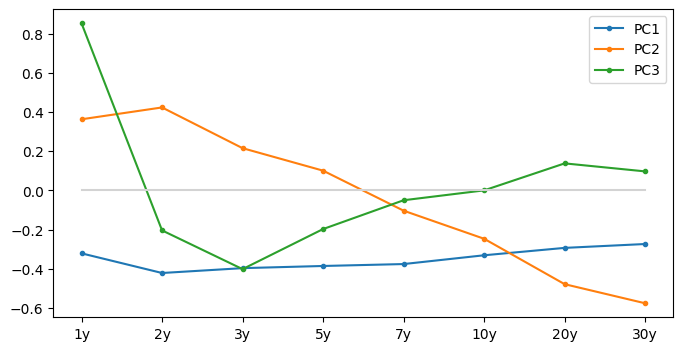

In [337]:
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 4)) 
ax = DataFrame(v, columns=[f'PC{j}' for j in range(1, n+1)], index=['1y', '2y', '3y', '5y', '7y', '10y', '20y', '30y']).iloc[:, :3].plot(style='.-', ax=ax)
ax.plot(range(8), np.zeros(8), color='lightgray');


## Scores

* Classic result: PC1 score volatility $\gg$ PC2 score volatility $\gg$ PC3 score volatility
* Given how tiny PC4 (and beyond) score volatility is, curve movements that can't be explained by the first 3 PCs are often treated as noise

In [338]:
(DataFrame(T, columns=[f'PC{j+1}' for j in range(n)])**2).mean().to_frame(name='Score Var').T

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Score Var,0.014254,0.001473,0.000414,0.000197,0.000085,0.000035,0.000028,0.00002


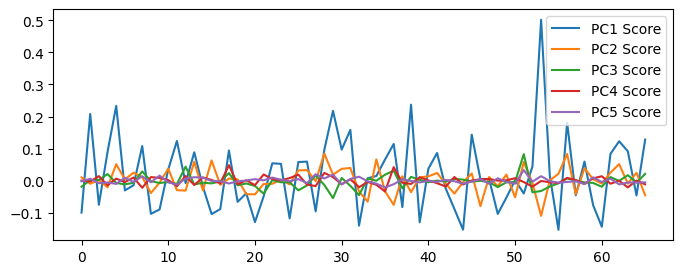

In [339]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 3)) 

DataFrame(T, columns=[f'PC{j} Score' for j in range(1, n+1)]).iloc[:, :5].plot(ax=ax);

## What Just Happened? The Implication

* Recall that $X = TV^{\mathsf T}$. We have established that a unitary matrix like $V$ is a rotation matrix, so $X$ and $T$ are the same data, simply rotated
* Think of rows of $X$ as independent sample points of the curve movement drawn from the same 8-dimensional distribution
* Rows of $T$ are then also independent sample points drawn from some 8-dimensional distribution
* One row of $X$ equals one row of $T$ multiplied by $V^{\mathsf T}$
    * This is a conclusion from the block matrix multiplication

## Block Matrix Multiplication

* If all $A, B, C, \ldots, H$ have the right sizes so that all the below operations are legal, then
$$
\begin{pmatrix}
\begin{array}{c|c}
  A & B\\
\hline
  C & D
\end{array}
\end{pmatrix}
\begin{pmatrix}
\begin{array}{c|c}
  E & F\\
\hline
  G & H
\end{array}
\end{pmatrix} = 
\begin{pmatrix}
\begin{array}{c|c}
  AE+BG & AF+BH\\
\hline
  CE+DG & CF+DH
\end{array}
\end{pmatrix}
$$
* Legal means for example
    * Number of columns in $A$ equals number of rows in $E$ so that the matrix multiplication $AE$ is defined
    * $AE$ and $BG$ have the the same size so that $AE + BG$ is defined
* That one row of $X$ equals one row of $T$ multiplied by $V^{\mathsf T}$ if $X = TV^{\mathsf T}$ is a special case where $X$ and $T$ are sliced into rows

## The Implication (Cont.)
* One row of $X$ equals one row of $T$ multiplied by $V$
\begin{align*}
\begin{pmatrix}
x_{11} & x_{12} & \cdots & x_{1n} 
\end{pmatrix} &=
\begin{pmatrix}
t_{11} & t_{12} & \cdots & t_{1n} 
\end{pmatrix} V^{\mathsf T}\\
&= \begin{pmatrix}
t_{11} & t_{12} & t_{13} & \cdots & t_{1n} 
\end{pmatrix}
\begin{pmatrix}
\frac{\qquad}{} & v_1^{\mathsf T} & \frac{\qquad}{}\\
\frac{\qquad}{} & v_2^{\mathsf T} & \frac{\qquad}{}\\
\frac{\qquad}{} & v_3^{\mathsf T} & \frac{\qquad}{}\\
&\vdots&\\
\end{pmatrix}\\
&= t_{11} \vec v_1^{\mathsf T} + t_{12} \vec v_2^{\mathsf T} + t_{13} \vec v_3^{\mathsf T} + t_{14} \vec v_4^{\mathsf T} + \cdots + t_{1n} \vec v_n^{\mathsf T}\\
&= t_{11} \vec v_1^{\mathsf T} + t_{12} \vec v_2^{\mathsf T} + t_{13} \vec v_3^{\mathsf T} + \vec\epsilon\\
\end{align*}

* We obtain a 3-factor model for the yield curve movement $\vec x$:
$$
\vec x = t_1 \vec v_1 + t_2 \vec v_2 + t_3 \vec v_3 + \vec\epsilon, 
$$
where $t_1$, $t_2$ and $t_3$ are random variables, $\vec\epsilon$ is a (small) random noise vector, and $\vec v_1$, $\vec v_2$ and $\vec v_3$ are PCs from the data

## Should We Center the Data?

* Centering the data means find the average yield curve movement and subtract the average from the data
* If we had centered the data with the average $\vec x_{\text{avg}}$, we would have got
\begin{align*}
\vec x = \vec x_{\text{avg}} + t_{1} \vec v_1 + t_{2} \vec v_2 + t_{3} \vec v_3 + \vec\epsilon\\
\end{align*}
* In practice, PCA is performed in a rolling period, and $\vec x_{\text{avg}}$ would be a moving average
* The 3-factor model is used to predict tomorrow's yield curve movement. Whether to use the version with a moving average is personal choice
* By not centering the data, we are saying $E[\vec x] = \vec x_{\text{avg}} = \vec 0$
* One simple assumption that can lead to $E[\vec x] = \vec 0$ is
$$
E[t_1] = E[t_2] = E[t_3] = 0,\qquad E[\vec\epsilon] = \vec 0
$$

## Uncorrelated Model Coefficients $t$'s

* In matrix form, the truncation of PC4 and beyond means
\begin{align*}
\begin{pmatrix}
x_{11} & x_{12} & \cdots & x_{1n} 
\end{pmatrix} &= \begin{pmatrix}
t_{11} & t_{12} & t_{13} & \cdots & t_{1n} 
\end{pmatrix}
\begin{pmatrix}
\frac{\qquad}{} & v_1^{\mathsf T} & \frac{\qquad}{}\\
\frac{\qquad}{} & v_2^{\mathsf T} & \frac{\qquad}{}\\
\frac{\qquad}{} & v_3^{\mathsf T} & \frac{\qquad}{}\\
&\vdots&\\
\end{pmatrix}_{n\times n}\\
&= \begin{pmatrix}
t_{11} & t_{12} & t_{13}
\end{pmatrix}
\begin{pmatrix}
\frac{\qquad}{} & v_1^{\mathsf T} & \frac{\qquad}{}\\
\frac{\qquad}{} & v_2^{\mathsf T} & \frac{\qquad}{}\\
\frac{\qquad}{} & v_3^{\mathsf T} & \frac{\qquad}{}
\end{pmatrix}_{3\times n} + \vec\epsilon\\
\end{align*}
* Stack the rows back to matrices:
\begin{align*}
X \approx \begin{pmatrix}
t_{11} & t_{12} & t_{13}\\
t_{21} & t_{22} & t_{23}\\
&\vdots&\\
t_{m1} & t_{m2} & t_{m3}
\end{pmatrix}_{m\times 3}
\begin{pmatrix}
\frac{\qquad}{} & v_1^{\mathsf T} & \frac{\qquad}{}\\
\frac{\qquad}{} & v_2^{\mathsf T} & \frac{\qquad}{}\\
\frac{\qquad}{} & v_3^{\mathsf T} & \frac{\qquad}{}
\end{pmatrix}_{3\times n}
\end{align*}

## Uncorrelated Model Coefficients $t$'s (Cont.)

$$
$$
\begin{align*}
X \approx \begin{pmatrix}
t_{11} & t_{12} & t_{13}\\
t_{21} & t_{22} & t_{23}\\
&\vdots&\\
t_{m1} & t_{m2} & t_{m3}
\end{pmatrix}_{m\times 3}
\begin{pmatrix}
\frac{\qquad}{} & v_1^{\mathsf T} & \frac{\qquad}{}\\
\frac{\qquad}{} & v_2^{\mathsf T} & \frac{\qquad}{}\\
\frac{\qquad}{} & v_3^{\mathsf T} & \frac{\qquad}{}
\end{pmatrix}_{3\times n}
\end{align*}
* $t$'s from the same column is realizations of a random variable
* We have 3 columns of realizations from 3 random variables
* We have established the assumption that all 3 random variables have mean 0

* Recall the property that, columns of the $T$ matrix have zero inner product: 
\begin{align*}
&t_{11}t_{12} + t_{21}t_{22} + \cdots + t_{m1}t_{m2} = 0,\\
&t_{11}t_{13} + t_{21}t_{23} + \cdots + t_{m1}t_{m3} = 0,\\
&t_{12}t_{13} + t_{22}t_{23} + \cdots + t_{m2}t_{m3} = 0
\end{align*}
* That means the 3 random variables are uncorrelated

## Sample Covariance and Correlation

* Recall that, if we have two random variables $Y$, $Z$, both **with mean zero**, and their samples $\{Y_j\}_{j=1}^m$, $\{Z_j\}_{j=1}^m$, the sample standard deviations and corvariance are
\begin{align*}
s_Y = \sqrt{\frac{\sum_{j=1}^n Y_j^2}{m-1}}, \qquad
s_Z = \sqrt{\frac{\sum_{j=1}^n Z_j^2}{m-1}}, \qquad
s_{YZ} = \frac{\sum_{j=1}^n Y_jZ_j}{m-1}, 
\end{align*}
respectively, and the correlation is $s_{YZ}/(s_Y s_Z)$
* When $n$ goes to infinity, the sample standard deviations and corvariance converge to the theoretical value
$$
\sqrt{E[Y^2]}, \qquad\sqrt{E[Z^2]}, \qquad E[YZ],
$$
respectively
* If $\sum_{j=1}^m Y_jZ_j = 0$, that will make the sample covariance and correlation both zero
* If we treat the random realizations $\{Y_j\}_{j=1}^m$ and $\{Z_j\}_{j=1}^m$ as two $m$-dimensional vectors, zero inner product of these two vectors means the sample correlation is zero

## 3-Factor Model

* The model: 
$$
\vec x = t_1 \vec v_1+ t_2 \vec v_2+ t_3 \vec v_3+ \vec\epsilon, 
$$
where $t_1$, $t_2$ and $t_3$ are random variables, $\vec\epsilon$ is a (small) random noise vector, and $\vec v_1$, $\vec v_2$ and $\vec v_3$ are PCs from the data
* Now we know $t_1$, $t_2$ and $t_3$ have zero sample correlations. A sensible assumption is that they are mutually independent
    * Be careful independence implies zero correlation, but the reverse is not true

* We have also established the assumptions
$$
E[t_1] = E[t_2] = E[t_3] = 0,\qquad E[\vec\epsilon] = \vec 0
$$

* The simplest concrete model is that $t_1$, $t_2$ and $t_3$ are independently normally distributed with mean zero, and variances estimated by data

## 3-Factor Model Summary

* Tomorrow's yield curve movement is
$$
\vec x = t_1 \vec v_1+ t_2 \vec v_2+ t_3 \vec v_3+ \vec\epsilon
$$
* $\vec\epsilon$ is a (small) random noise vector
* $\vec v_1$, $\vec v_2$ and $\vec v_3$ are PCs from the data
* $t_1$, $t_2$ and $t_3$ are independent normal random variables with mean 0, and their variances are estimated by data:

In [340]:
(DataFrame(T, columns=[f'PC{j+1}' for j in range(n)])**2).mean().to_frame(name='Score Var').T

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Score Var,0.014254,0.001473,0.000414,0.000197,0.000085,0.000035,0.000028,0.00002


$$
t_1\sim N(0, 0.014254)\qquad t_2\sim N(0, 0.001473)\qquad t_3\sim N(0, 0.000414)
$$

## PCs Revisited
$$
\vec x = t_1 \vec v_1+ t_2 \vec v_2+ t_3 \vec v_3 + \vec\epsilon
$$
* PC1 is close to parallel shift
* PC2 controls the slope of the curve
* PC3 controls the curvature

In [341]:
import numpy

X = -table('daily-treasury-rates').head(67).iloc[:, 6:].diff().dropna().values

m, n = X.shape

u, s, vt = numpy.linalg.svd(X)

T = u[:, :n] * s

v = vt.T

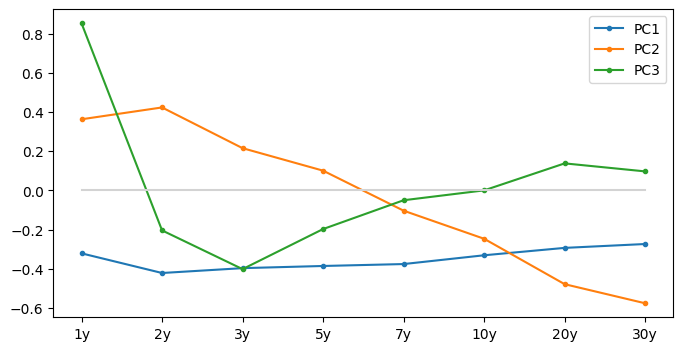

In [342]:
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 4)) 
ax = DataFrame(v, columns=[f'PC{j}' for j in range(1, n+1)], index=['1y', '2y', '3y', '5y', '7y', '10y', '20y', '30y']).iloc[:, :3].plot(style='.-', ax=ax)
ax.plot(range(8), np.zeros(8), color='lightgray');


## PC1 Scenarios: Parallel Shift

* Holding $t_2 = t_3 = 0$. A few possible realizations of $t_1$ (std amplified 10 times for a better visualization, and same for PC2 and PC3 scenarios below)

In [343]:
import numpy as np

n_scenarios = 5

# PCs
v1, v2, v3 = v[:, :3].T  

# std of coefficients
std1, std2, std3 = 10*np.sqrt((DataFrame(T, columns=[f'PC{j+1}' for j in range(n)])**2).mean()).to_frame(name='Score Var').values.flatten()[:3]

# random scenarios
t1_scenarios = np.random.normal(loc=0, scale=std1, size=n_scenarios)
t2_scenarios = np.random.normal(loc=0, scale=std2, size=n_scenarios)
t3_scenarios = np.random.normal(loc=0, scale=std3, size=n_scenarios)

print(t1_scenarios)

[ 1.29061263 -1.91333395 -1.01081064 -1.42220717  0.28616997]


* Scenario curves:
$$\text{Tomorrow's Curve $=$ Today's Curve $+\vec x + \vec\epsilon =$ Today's Curve $+t_1 \vec v_1 + \vec\epsilon$}
$$

In [344]:
import pandas as pd

curve_today = table('daily-treasury-rates').head(1).iloc[:, 6:].T

pc1_scenario_curves = pd.concat([curve_today, DataFrame(np.outer(v1, t1_scenarios) + curve_today.values, index=curve_today.index, columns=[f's{j}' for j in range(1, n_scenarios+1)])], axis='columns')

pc1_scenario_curves

,10/17/2025,s1,s2,s3,s4,s5
1y,3.56,3.145144,4.175025,3.884916,4.017156,3.468013
2y,3.46,2.915720,4.266895,3.886281,4.059776,3.339316
3y,3.47,2.957706,4.229477,3.871230,4.034529,3.356408
5y,3.59,3.091960,4.328345,3.980066,4.138822,3.479569
7y,3.78,3.294604,4.499600,4.160163,4.314888,3.672372
10y,4.02,3.592454,4.653837,4.354855,4.491140,3.925199
20y,4.58,4.201118,5.141693,4.876741,4.997514,4.495990
30y,4.60,4.246604,5.123910,4.876781,4.989430,4.521641


## PC1 Scenarios: Parallel Shift (Cont.)

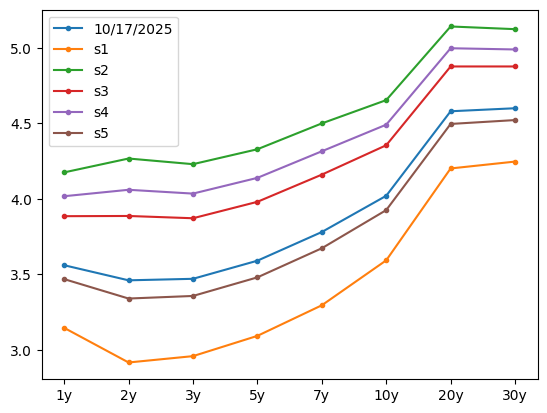

In [345]:
pc1_scenario_curves.plot(style='.-');

## PC2 Scenarios: Slope Change

* Holding $t_1 = t_3 = 0$. A few possible realizations of $t_2$: 

In [346]:
print(t2_scenarios)

[-0.09221954 -0.09366528 -0.35735591 -0.09354906 -0.18492912]


* Scenario curves:
$$
\text{Tomorrow's Curve $=$ Today's Curve $+t_2 \vec v_2 + \vec\epsilon$}
$$

In [347]:
pc2_scenario_curves = pd.concat([curve_today, DataFrame(np.outer(v2, t2_scenarios) + curve_today.values, index=curve_today.index, columns=[f's{j}' for j in range(1, n_scenarios+1)])], axis='columns')

pc2_scenario_curves

,10/17/2025,s1,s2,s3,s4,s5
1y,3.56,3.526554,3.526030,3.430396,3.526072,3.492931
2y,3.46,3.420985,3.420374,3.308816,3.420423,3.381763
3y,3.47,3.450150,3.449839,3.393082,3.449864,3.430195
5y,3.59,3.580736,3.580591,3.554101,3.580602,3.571423
7y,3.78,3.789568,3.789718,3.817076,3.789706,3.799187
10y,4.02,4.042783,4.043140,4.108285,4.043111,4.065687
20y,4.58,4.624153,4.624845,4.751094,4.624789,4.668540
30y,4.60,4.653139,4.653972,4.805918,4.653905,4.706561


## PC2 Scenarios: Slope Change (Cont.)

* Curve can "steepen" or "flatten"

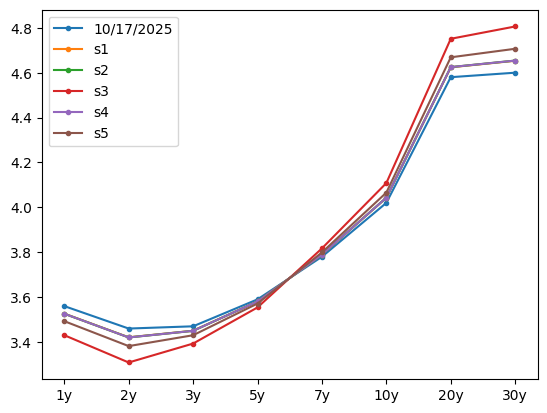

In [348]:
pc2_scenario_curves.plot(style='.-');

## PC3 Scenarios: Curvature Change

* Holding $t_1 = t_2 = 0$. A few possible realizations of $t_3$: 

In [349]:
print(t3_scenarios)

[ 0.00803162 -0.00072979 -0.08835312  0.17060337  0.01578796]


* Scenario curves:
$$
\text{Tomorrow's Curve $=$ Today's Curve $+t_3 \vec v_3 + \vec\epsilon$}
$$

In [350]:
pc3_scenario_curves = pd.concat([curve_today, DataFrame(np.outer(v3, t3_scenarios) + curve_today.values, index=curve_today.index, columns=[f's{j}' for j in range(1, n_scenarios+1)])], axis='columns')

pc3_scenario_curves

,10/17/2025,s1,s2,s3,s4,s5
1y,3.56,3.566847,3.559378,3.484676,3.705446,3.573460
2y,3.46,3.458359,3.460149,3.478053,3.425140,3.456774
3y,3.47,3.466772,3.470293,3.505515,3.401424,3.463654
5y,3.59,3.588414,3.590144,3.607448,3.556310,3.586882
7y,3.78,3.779595,3.780037,3.784459,3.771391,3.779203
10y,4.02,4.019999,4.020000,4.020007,4.019986,4.019999
20y,4.58,4.581106,4.579900,4.567838,4.603483,4.582173
30y,4.60,4.600777,4.599929,4.591452,4.616505,4.601527


## PC3 Scenarios: Curvature Change (Cont.)

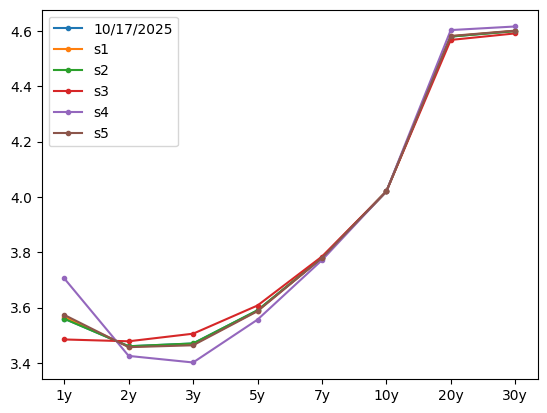

In [351]:
pc3_scenario_curves.plot(style='.-');

## Cumulative Percentage of Variance Explained

* Recall the score matrix
$$
T = \begin{pmatrix}
t_{11} & t_{12} & \cdots & t_{1n}\\
t_{21} & t_{22} & \cdots & t_{2n}\\\\
&&\vdots& \\\\
t_{m1} & t_{m2} & \cdots & t_{mn}
\end{pmatrix}_{m\times n}
$$
* We assume each column are realizations of a random variable with mean 0
* Under the assumption, we find sample variance column by column. For example, the first column gives the variance $\sum_{j=1}^m t_{j1}^2/m = 0.014254$, as listed below

In [352]:
score_var = (DataFrame(T, columns=[f'PC{j+1}' for j in range(n)])**2).mean().to_frame(name='Score Var').T
score_var

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Score Var,0.014254,0.001473,0.000414,0.000197,0.000085,0.000035,0.000028,0.00002


## Cumulative Percentage of Variance Explained (Cont.)

* Denote the variances by $\text{Var}_1, \text{Var}_2, \ldots, \text{Var}_n$:
$$
\text{Var}_k = \frac{1}{m}\sum_{j=1}^m t_{jk}^2
$$
* The cumulative percentage of variance explained by the first $k$ PCs are defined by
$$
\frac{\text{Var}_1 + \text{Var}_2 + \cdots + \text{Var}_k}{\text{Var}_1 + \text{Var}_2 + \text{Var}_3 + \cdots + \text{Var}_n}
$$
* Given the above data, the cumulative percentage of variance explained are

In [353]:
var_explained = score_var.cumsum(axis='columns')/score_var.values.sum()
var_explained.index = ["Var Explained"]
var_explained

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Var Explained,0.863574,0.952807,0.977915,0.989821,0.994952,0.997095,0.998814,1.0


* PC1 alone explains 86\% of the curve movement (the variances), PC1 and PC2 together explain 95\%, and the first 3 PCs together explain almost 98\%, which is quite common

## Cumulative Percentage of Variance Explained (Cont..)

* Recall the score matrix
$$
T = US = \begin{pmatrix}
t_{11} & t_{12} & \cdots & t_{1n}\\
t_{21} & t_{22} & \cdots & t_{2n}\\\\
&&\vdots& \\\\
t_{m1} & t_{m2} & \cdots & t_{mn}
\end{pmatrix}_{m\times n} = 
\begin{pmatrix}
\\
|&|&  & | \\\\
s_{11} \vec u_1 & s_{22} \vec u_2 & \cdots & \vec s_{nn}u_n \\\\
|&|&  & | \\\\
\end{pmatrix}_{m\times n}
$$
and recall that $\vec u_j$ has norm 1, so we have
\begin{align*}
\text{Var}_k = \frac{1}{m}\sum_{j=1}^m t_{jk}^2 = \frac{s_{kk}^2}{m} \sum_{j=1}^m u_{jk}^2 = \frac{s_{kk}^2}{m}
\end{align*}
and hence
$$
\frac{\text{Var}_1 + \text{Var}_2 + \cdots + \text{Var}_k}{\text{Var}_1 + \text{Var}_2 + \text{Var}_3 + \cdots + \text{Var}_n} = \frac{s_{11}^2 + s_{22}^2 + \cdots + s_{kk}^2}{s_{11}^2 + s_{22}^2 + s_{33}^2 + \cdots + s_{nn}^2}
$$

## Cumulative Percentage of Variance Explained (Cont...)

```python

u, s, vt = numpy.linalg.svd(X)

(s**2).cumsum()/(s**2).sum()
```

In [360]:
# u, s, vt = numpy.linalg.svd(X)

print((s**2).cumsum()/(s**2).sum())

[0.86357429 0.95280679 0.97791528 0.9898212  0.994952   0.99709507
 0.99881385 1.        ]


* Same as the previous table computed from the $T$ matrix

In [361]:
var_explained

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Var Explained,0.863574,0.952807,0.977915,0.989821,0.994952,0.997095,0.998814,1.0


## Applications in Hedging

* Recall that, given the Delta ladder and the curve movement, we can compute the PnL of a portfolio
* Having a model for tomorrow's yield curve movement means having a model for tomorrow's portfolio PnL

In [390]:
delta_ladder = table('yc_10022025_10032025').iloc[-8:, 3].to_frame().T
delta_ladder

,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Portfolio Delta Ladder,-3739,-2320,314,-65,23,-6,1,0


* Denote by $\vec d$ the 8-dimensional Delta ladder
* Recall that rows of $X$ are the daily yield curve movement, treated as independent sample points: 

In [381]:
-table('daily-treasury-rates').head(4).iloc[:, 6:].diff().dropna()

,1y,2y,3y,5y,7y,10y,20y,30y
10/16/2025,0.02,0.05,0.05,0.04,0.04,0.03,0.02,0.02
10/15/2025,-0.07,-0.09,-0.09,-0.08,-0.08,-0.06,-0.05,-0.06
10/14/2025,0.03,0.02,0.04,0.03,0.03,0.02,0.02,0.02


* $X\vec d$ is the daily PnL, a 66-dimensional vector
    * "If, on 10/16/2025, my portfolio Delta ladder is $\vec d$, what'd have been the PnL?"

## Daily PnL

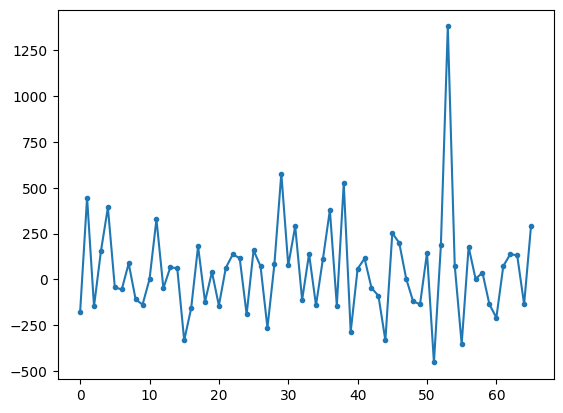

In [384]:
DataFrame(X @ d).plot(style='.-', legend=None);

## PnL Attribution

$$
$$
\begin{align*}
X_{m\times n}\vec d &= TV^{\mathsf T} d \\
&= T_{m\times n}(V^{\mathsf T} d)_{n\times 1} \approx 
\langle v_1, \vec d\rangle
\begin{pmatrix}
t_{11} \\
t_{21} \\
\vdots \\
t_{m1}
\end{pmatrix} + 
\langle v_2, \vec d\rangle
\begin{pmatrix}
t_{12} \\
t_{22} \\
\vdots \\
t_{m2}
\end{pmatrix} + 
\langle v_3, \vec d\rangle
\begin{pmatrix}
t_{13} \\
t_{23} \\
\vdots \\
t_{m3}
\end{pmatrix}
\end{align*}

* The 1st term is the daily PnL contributed by PC1 (parallel shift of the curve)
* The 2nd term is the daily PnL contributed by PC2 (slope change of the curve)
* The 3nd term is the daily PnL contributed by PC3 (curvature change of the curve)

## PnL Attribution (Cont.)

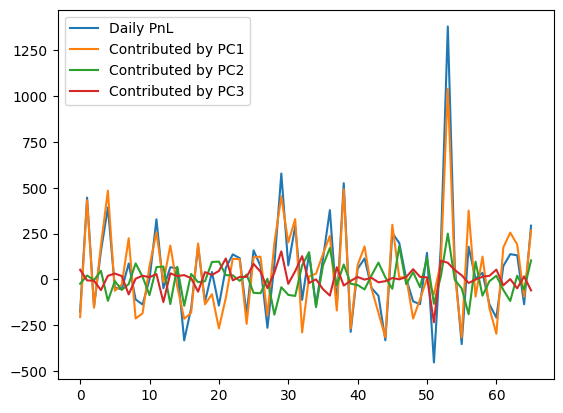

In [389]:
t1 = T.T[0]
t2 = T.T[1]
t3 = T.T[2]

DataFrame({'Daily PnL': X @ d, 
           'Contributed by PC1': (v1 @ d)*t1, 
           'Contributed by PC2': (v2 @ d)*t2, 
           'Contributed by PC3': (v3 @ d)*t3}).plot();

## PnL Prediction

* Tomorrow's PnL is 
$$
\langle\vec x, \vec d\rangle \approx t_1\langle v_1, \vec d\rangle + t_2\langle v_2, \vec d\rangle + t_3\langle v_3, \vec d\rangle
$$
* This is random as the coefficients $t_1$, $t_2$ and $t_3$ are random
    * Recall that $\text{Var}(t_1) \gg \text{Var}(t_2) \gg \text{Var}(t_3)$
* The 3 terms on the right hand side are PnL contributed by PC1, PC2 and PC3, respectively
* As we have seen, PnL are mostly contributed by PC1 the parallel shift of the curve
    * This is a consequence of the fact that PC1 has by far the most volatile scores

## Hedging out PC1 Risk

* If we can hedge out PC1 risk, the portfolio will be much less volatile
* We buy a 10y ZCB paying $\$1$ at maturity, whose Delta ladder is as below
    * Recall that a ZCB's duration is its term
    * We choose 10y as the hedge instrument as it's the most liquid

In [413]:
bond_10y_delta = DataFrame([[0, 0, 0, 0, 0, -10, 0, 0]], columns=delta_ladder.columns, index=['Hedge Inst Delta'])
bond_2y_delta = DataFrame([[0, -2, 0, 0, 0, 0, 0, 0]], columns=delta_ladder.columns, index=['Hedge Inst Delta'])
bond_10y_delta

,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Hedge Inst Delta,0,0,0,0,0,-10,0,0


* Denote this Delta ladder of the hedge instruemnt as $\vec b_1$

## Hedge Ratio

* Adding $h$ units of the hedge instrument into the portfolio, the portfolio Delta ladder becomes $\vec d + h \vec b_1$ and tomorrow's PnL becomes
$$
\langle\vec x, \vec d + h \vec b_1\rangle \approx t_1\langle v_1, \vec d + h \vec b_1\rangle + t_2\langle v_2, \vec d + h \vec b_1\rangle + t_3\langle v_3, \vec d + h \vec b_1\rangle
$$
* If we want to hedge out PC1 risk, we must have $\langle v_1, \vec d + h \vec b_1\rangle = 0$
    * If this term is zero, the PnL can only come from less volatile $t_2$ and $t_3$

* We have
$$
0 = \langle v_1, \vec d + h \vec b_1\rangle = \langle v_1, \vec d\rangle + h \langle v_1, \vec b_1\rangle, 
$$
or
$$
h = -\frac{\langle v_1, \vec d\rangle}{\langle v_1, \vec b_1\rangle}
$$
* This is the hedge ratio. This is how much of the hedge instrument we must add to the portfolio to make it immue to curve parallel shift

## Hedge Ratio: Exercise


* Given the portfolio Delta ladder

In [401]:
delta_ladder

,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Portfolio Delta Ladder,-3739,-2320,314,-65,23,-6,1,0


* And the Delta ladder of a 10y ZCB paying $\$1$ at maturity

In [409]:
bond_10y_delta

,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Hedge Inst Delta,0,0,0,0,0,-10,0,0


* And the PC1 vector

In [411]:
print(v1)

[-0.32144131 -0.42172197 -0.39693884 -0.3858943  -0.37609721 -0.33127384
 -0.29356772 -0.27382061]


* Please compute the hedge ratio

## Hedging out Both PC1 and PC2 Risk

* One can hedge out both PC1 and PC2 risk to make the portfolio immune to both parallel shift and slope change of the curve
* We buy $h_1$ units of 10y ZCB paying $\$1$ at maturity, whose Delta ladder, denoted by $\vec b_1$, is as below

In [417]:
bond_10y_delta

,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Hedge Inst Delta,0,0,0,0,0,-10,0,0


* We further buy $h_2$ units of 2y ZCB paying $\$1$ at maturity, whose Delta ladder, denoted by $\vec b_2$, is as below

In [415]:
bond_2y_delta

,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Hedge Inst Delta,0,-2,0,0,0,0,0,0


## Hedging out Both PC1 and PC2 Risk (Cont.)

* The hedged portfolio Delta ladder is $\vec d + h_1 \vec b_1 + h_2 \vec b_2$ and tomorrow's PnL becomes
\begin{align*}
&\langle\vec x, \vec d + h_1 \vec b_1 + h_2 \vec b_2\rangle \\
&\approx t_1\langle v_1, \vec d + h_1 \vec b_1 + h_2 \vec b_2\rangle + t_2\langle v_2, \vec d + h_1 \vec b_1 + h_2 \vec b_2\rangle + t_3\langle v_3, \vec d + h_1 \vec b_1 + h_2 \vec b_2\rangle
\end{align*}
* In order to hedge out both PC1 and PC2 risk, we must have 
\begin{align*}
0 &= \langle v_1, \vec d + h_1 \vec b_1 + h_2 \vec b_2\rangle = \langle v_1, \vec d\rangle + h_1 \langle v_1, \vec b_1\rangle + h_2 \langle v_1, \vec b_2\rangle,\\
0 &= \langle v_2, \vec d + h_1 \vec b_1 + h_2 \vec b_2\rangle = \langle v_2, \vec d\rangle + h_1 \langle v_2, \vec b_1\rangle + h_2 \langle v_2, \vec b_2\rangle
\end{align*}
* If these two terms are both zero, tomorrow's PnL can only come from much less volatile $t_3$
* This linear system can be solved to obtain the hedge ratios, that's units of 10y and 2y ZCB we need to buy to make the portfolio immune to both parallel shift and slope change of the curve